<img align="right" width="250" src="http://www.sobigdata.eu/sites/default/files/logo-SoBigData-DEFINITIVO.png">
**Author:** [Riccardo Guidotti](http://kdd.isti.cnr.it/people/riccardo-guidotti)  
**Python version:**  3.x

<img align="right" width="250" src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Cluster-2.svg/601px-Cluster-2.svg.png">

# Clustering with Python

This notebook contains an overview of basic python functionalities for clustering using the [sklearn](http://scikit-learn.org/stable/) library.  
Note: this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started.

Import of the basic packages to use

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<img align="right" width="150" src="https://archive.ics.uci.edu/ml/assets/MLimages/Large53.jpg">

## Iris Dataset  
[Link](https://archive.ics.uci.edu/ml/datasets/iris) to the dataset on the UCI Machine Learning Repository.  
As first step we load the whole Titanic Dataset and make confidence with its features.  

In [2]:
df = pd.read_csv("../dataset/iris.csv", skipinitialspace=True, 
                 sep=',')
df.head()

,sepal length,sepal width,petal length,petal width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
sepal length    150 non-null float64
sepal width     150 non-null float64
petal length    150 non-null float64
petal width     150 non-null float64
class           150 non-null object
dtypes: float64(4), object(1)
memory usage: 5.9+ KB


The data set contains 3 classes of 50 instances each, where each class refers to a type of iris plant.  
The predictive attribute is the class of the iris plant. 

Fetures:
* sepal length (in cm)
* sepal width (in cm)
* petal length (in cm) 
* petal width (in cm) 
* class: Iris-setosa, Iris-versicolour, Iris-virginica

Since clustering is an ***unsupervised*** task we save the class attribute in a varable and we remove it from the dataframe.

In [4]:
classes = df['class']
del df['class']
df.head()

,sepal length,sepal width,petal length,petal width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


## Data Understanding

We observe the distributions of the attributes without considering the class.

In [5]:
from pandas.plotting import scatter_matrix

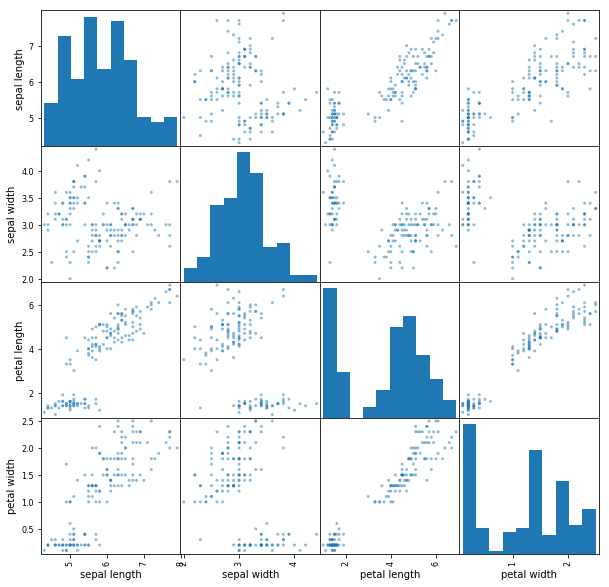

In [6]:
scatter_matrix(df, figsize=(10, 10))
plt.show()

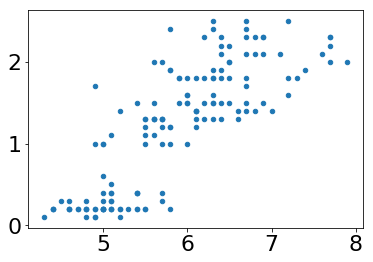

In [7]:
plt.scatter(df['sepal length'], df['petal width'], s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

## Clustering Objective
Grouping a set of instances such that the instances in the same cluster are more ***similar*** (in some sense) to each other than to those in other clusters.  
The result of a clustering algorithm is a ***clustering***, that is a set of clusters.
Clustering is an ***unsupervised*** task, i.e., the real cluster partitioning is unknown.  

## Different Types of Clusterings and Clusters

Principal Types of Clustering:
* **Partitional Clustering:** division into non-overlapping clusters, i.e., each instance is only in one cluster
* Hierarchical Clustering: set of nested clusters organized as a hierarchical tree

Principal Types of Clusters:
* **Center-based:** the calculus is based on a centroid (K-Means)
* **Density-based:** the calculus is based on a concept of neighborhood and density (DBSCAN)

Center-based: <img align="center" src="kmeans.png">
Density-based: <img align="center" src="dbscan.png">

## Clustering Preprocessing - Normalization  
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [9]:
scaler = StandardScaler()
scaler.fit(df.head().values)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
df.head().values

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [11]:
scaler.transform(df.head().values)

array([[ 1.29399328,  0.95025527,  0.        ,  0.        ],
       [ 0.21566555, -1.2094158 ,  0.        ,  0.        ],
       [-0.86266219, -0.34554737, -1.58113883,  0.        ],
       [-1.40182605, -0.77748158,  1.58113883,  0.        ],
       [ 0.75482941,  1.38218948,  0.        ,  0.        ]])

In [12]:
scaler.inverse_transform(scaler.transform(df.head().values))

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [13]:
scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)

In [14]:
X[:5]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667]])

# K-Means

## The Algorithm in a Nutshell

**Objective:** Clusters the data into $k$ groups.
* **Init step:** Select k points at random as cluster centers.
* **Assignment step:** Assign each instance to the cluster with the closest mean according to the distance function.
* **Update step**: Calculate the new means to be the centroids of the instances in the new clusters.
* ***Repeat*** steps 2 and 3 until the assignment no longer change.

There is no guarantee that the optimum is found using this algorithm.

> Tan, P. N. (2006). Introduction to data mining. Pearson Education India.

Running [example](http://matlaspisa.isti.cnr.it:5055/K-Means)
Wikipedia [link](https://en.wikipedia.org/wiki/K-means_clustering)

## K-Means Problems

* Initial Centroids
* Number of clusters

## K-Means in Python  ([sklearn](http://scikit-learn.org/stable/modules/clustering.html#k-means))

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the k-means algorithm for a single run.

In [16]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

Labels

In [17]:
kmeans.labels_[:5]

array([1, 1, 1, 1, 1], dtype=int32)

Observing the size of each cluster

In [18]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([39, 50, 61]))

In [19]:
hist, bins = np.histogram(kmeans.labels_, 
                          bins=range(0, len(set(kmeans.labels_)) + 1))
dict(zip(bins, hist))

{0: 39, 1: 50, 2: 61}

Visualization of the clustering in two dimensions.

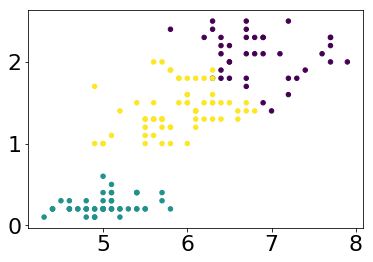

In [20]:
plt.scatter(df['sepal length'], df['petal width'], 
            c=kmeans.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Centers

In [21]:
kmeans.cluster_centers_

array([[0.70726496, 0.4508547 , 0.79704476, 0.82478632],
       [0.19611111, 0.595     , 0.07830508, 0.06083333],
       [0.44125683, 0.30737705, 0.57571548, 0.54918033]])

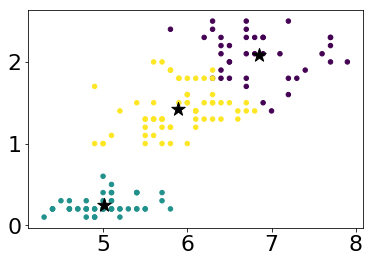

In [22]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

plt.scatter(df['sepal length'], df['petal width'], c=kmeans.labels_, 
            s=20)
plt.scatter(centers[:, 0], centers[:, 3], s=200, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Visualization of clusters centers by means of parallel coordinates

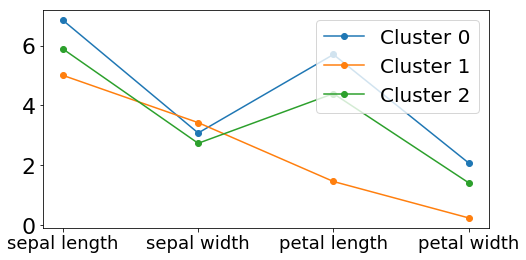

In [23]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(df.columns)), df.columns, fontsize=18)
plt.legend(fontsize=20)
plt.show()

SSE and Clustering Validation

In [24]:
print('SSE %s' % kmeans.inertia_)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))

SSE 6.982216473785234
Silhouette 0.5047687565398589


Knee Method to estimate the best K

In [25]:
sse_list = list()
max_k = 50
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

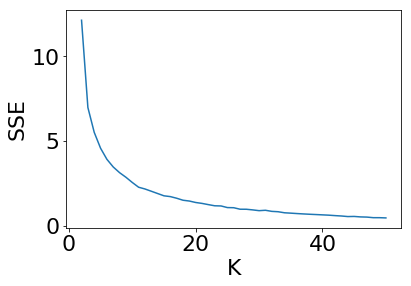

In [26]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# DBSCAN

## The Algorithm in a Nutshell

* A point is a **core** if it has more than minPts points within eps
* A point is a **border** if it has less than minPts points within eps but one of its neighboors is a core point
* A **noise** point is neither a core or a border point


1. Label all points as core, border or noise points
1. Eliminate noise points.
1. Put an edge between all core points that are within eps of each other
1. Make each group of connected core points into a separate cluster.
1. Assign each border point to one of the clusters of its associated core points.

> Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996, August). A density-based algorithm for discovering clusters in large spatial databases with noise. In Kdd (Vol. 96, No. 34, pp. 226-231).

Running [example](http://matlaspisa.isti.cnr.it:5055/Dbscan)  
Wikipedia [link](https://en.wikipedia.org/wiki/DBSCAN)

## DBSCAN Problems

* Parameter tuning
* Does not recognize different densities

## DBSCAN in Python ([sklearn](http://scikit-learn.org/stable/modules/clustering.html#dbscan))

In [27]:
from sklearn.cluster import DBSCAN

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [28]:
dbscan = DBSCAN(eps=0.22, min_samples=5)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=0.22, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=5, n_jobs=None, p=None)

Output:
* **labels_**: Cluster labels for each point in the dataset. Noisy samples are given the label -1.

Labels

In [29]:
dbscan.labels_[:5]

array([0, 0, 0, 0, 0])

Observing the size of each cluster

In [30]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 3, 49, 98]))

Visualization of the clustering in two dimensions.

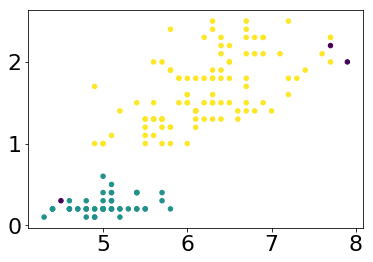

In [31]:
plt.scatter(df['sepal length'], df['petal width'], c=dbscan.labels_, s=20)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

Clustering Validation

In [32]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.555867914558612


Knee Method to estimate the best eps

In [33]:
from scipy.spatial.distance import pdist, squareform

In [34]:
dist = pdist(X, 'euclidean')
dist = squareform(dist)

In [35]:
k = 5
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

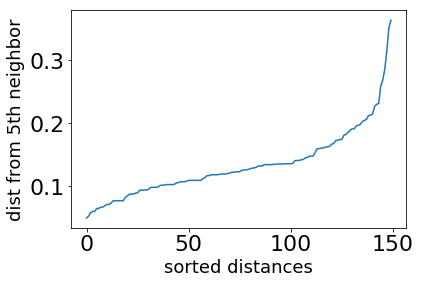

In [36]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# Hierarchical Clustering

In [37]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

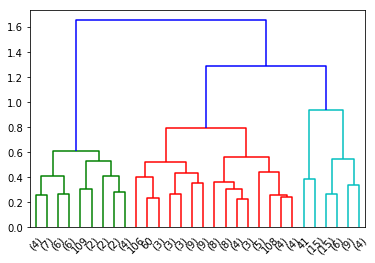

In [38]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.0, truncate_mode='lastp')

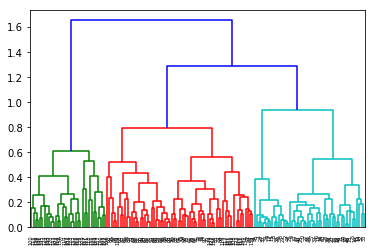

In [39]:
res = dendrogram(data_link, color_threshold=1.0)

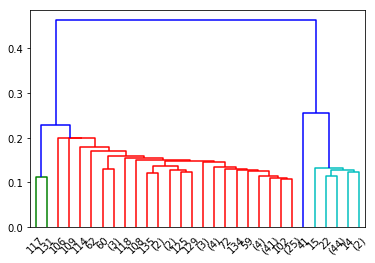

In [40]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.2, truncate_mode='lastp')

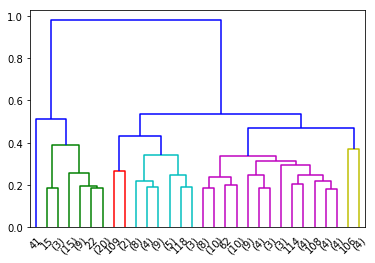

In [41]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.4, truncate_mode='lastp')